<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">IFT 6132 - Project</div>

# I) Import and visualize the data

* To read the 3D models in ".ply", we will use two packages  [open3d]( http://www.open3d.org/docs/index.html) and [trimesh]( https://trimsh.org/index.html )
* To merge several meshs into one same file, we will need [blender]( https://www.blender.org ) as backend
* The ".ply" files we'll use are available here: https://www.cc.gatech.edu/projects/large_models/
* To visualize the cloud points in the Notebook, node.js needs to be installed: https://nodejs.org/en/download/package-manager/


In [1]:
import numpy as np
import trimesh
import trimesh.viewer
import open3d as o3
from open3d import JVisualizer

To train our GANs, we will need a dataset to train it on. To have that, we will sample uniformely points of the models and then aggregate the point clouds generated in the same dataset, avoiding overlaps.

In [2]:
def sample_point_cloud_from_models(model_path, n_points):
    
    """Uniformely sample the surface of a given mesh and returns a dataset of n_points points.
    
    Parameters:
        
        - model_path: str, the path to the model (in '.ply')
        - n_points: int, the number of points to sample
        
    Returns:
    
        - data: a n_points x 3 array containing the samples"""
    
    mesh = trimesh.load_mesh(model_path)
    data = trimesh.sample.sample_surface(mesh, n_points)[0]
    
    return(data)

In [3]:
def generate_dataset(models_list, n_points, visualize=True, save_points = False):
    
    """ Generate point clouds from the models and aggregate them in a single array, avoiding overlaps between the point clouds.
    
    Parameters: 
    
        - models_list:  list of the models path names. (example: ['bunny.ply'])
        - n_points: int, the number of points to sample for each model
        - visualize: boolean, if True then display the point clouds
    
    Returns: 
    
        - points: an Nx3 array containing the N = n_points x len(models_list) 3D points from the models
        - gap_values: list of the values of the gaps between the point clouds
        - mesh: trimesh mesh of the union of all the models of models_list"""
    
    # load a point cloud
    model0 = models_list.pop()
    points = sample_point_cloud_from_models(model0, n_points)
    # initialize the mesh of the union of models
    meshs = [trimesh.load_mesh(model0)]
    gap_values = []
    
    for k in range(len(models_list)):
        
        # load a point cloud
        points_model = sample_point_cloud_from_models(models_list[k], n_points)
        # compute the gap between the 3D point clouds
        maxi = np.max(points[:,0], axis=0)
        mini = np.min(points_model[:,0], axis=0)
        gap = maxi - mini
        gap_values.append(gap + gap/10)
        translation = np.array([gap + gap/10, 0,0])
        # translate the added point cloud so that they don't intersect
        points_model += translation
        # add the new point cloud to the array containing all the data
        points = np.concatenate((points, points_model), axis=0)
        # compute the mesh of the added model
        mesh_model = trimesh.load_mesh(models_list[k])
        mesh_model.vertices += translation
        meshs.append(mesh_model)
    
    # compute the mesh of the union
    if len(models_list) > 1:
        mesh = trimesh.boolean.union(meshs, 'blender')
    else:
        mesh = meshs[0]
    
    # save the point cloud as a csv
    if save_points:
        np.savetxt("points.csv", points, delimiter=",")
    
    if visualize:
        
        # display the resulting point cloud
        pcd = o3.PointCloud()
        pcd.points = o3.Vector3dVector(points)
        visualizer = JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    
    return(points, gap_values, mesh)

In [4]:
point_cloud, gaps, mesh = generate_dataset(['bunny.ply'], 10000, visualize=False)
np.shape(point_cloud)

(10000, 3)

![title](bunny_dragon_pcd.png)

# II) Definition of the task losses we'll use

## 1) Distances between two point clouds

One way to assess the quality of our generator would be to compare the point cloud it generated to a point cloud *(of the same size)* coming from the "true" model.

### a) The Hausdorff distance

The directed Hausdorff $\tilde{H}$ distance between two point clouds $P,Q$ is the biggest gap that exists between the two surfaces:
 <h3 align="center"> $\tilde{H}(P,Q) = \max_{p \in P} \Big( \min_{q \in Q} \Vert p - q \Vert_2 \Big)$ </h3>
 As $\tilde{H}(P,Q) \neq \tilde{H}(Q,P)$, we symetrize the distance and use:
 <h3 align="center"> $H(P,Q) = \max \{ \tilde{H}(P,Q), \tilde{H}(Q,P) \}$ </h3>
 
It is a widely used distance to compare point clouds [1]. We will use the implementation of $\texttt{scipy.spatial}$ to do that.

**sources:**

[1] **A. A. Taha and A. Hanbury**, [“An efficient algorithm for calculating the exact Hausdorff distance.”]( https://publik.tuwien.ac.at/files/PubDat_247739.pdf ) *IEEE Transactions On Pattern Analysis And Machine Intelligence, vol. 37 pp. 2153-63, 2015.*

In [5]:
from scipy.spatial.distance import directed_hausdorff

In [6]:
def compute_hausdorff_distance(P,Q):
    
    """Compute the Hausdorff distance between two point clouds
    
    parameters:
    
        - P: an N_p x 3 array containing the 3D points from the first point cloud
        - Q: an N_q x 3 array containing the 3D points from the second point cloud
    
    returns:
    
        - H(P,Q): the symetrized Hausdorff distance between P and Q """
    
    return(max(directed_hausdorff(P, Q)[0], directed_hausdorff(Q, P)[0]))

### b) The chamfer distance

As defined in [2], the Chamfer pseudo distance $d_{CH}$ between two point clouds $P,Q$ measures the squared distance between each
point in one set $P$ to its nearest neighbor in the other set $Q$:
 <h3 align="center"> $d_{CH}(P,Q) = \sum_{p\in P} \min_{q\in Q} \Vert p- q \Vert_2^2 + \sum_{q \in Q} \min_{p \in P} \Vert p - q \Vert_2^2$ </h3>
 
 **sources:**
 
 [2] **Panos Achlioptas, Olga Diamanti, Ioannis Mitliagkas, and Leonidas Guibas.** [Learning representations
and generative models for 3d point clouds.]( https://arxiv.org/pdf/1707.02392.pdf ) *arXiv preprint arXiv:1707.02392, 2017*

In [7]:
from sklearn.neighbors import NearestNeighbors

In [8]:
def compute_chamfer_distance(P,Q):
    
    """Compute the Chamfer pseudo distance between two point clouds
    
    parameters:
    
        - P: an N_p x 3 array containing the 3D points from the first point cloud
        - Q: an N_q x 3 array containing the 3D points from the second point cloud
    
    returns:
    
        - d_CH(P,Q): float, the Chamfer pseudo distance between P and Q """

    # Initialize the Nearest Neighbors method for P and Q
    neigh_P = NearestNeighbors().fit(P)
    neigh_Q = NearestNeighbors().fit(Q)
    # Compute the distances
    dist_P, _ = neigh_P.kneighbors(Q, 1, return_distance=True)
    dist_Q, _ = neigh_Q.kneighbors(P, 1, return_distance=True)
    # Compute the sums
    sum_P = np.sum(dist_P**2)
    sum_Q = np.sum(dist_Q**2)
    
    return(sum_P + sum_Q)

## 2) Distances between a reconstructed manifold and a point cloud

An other way to assess the quality of the generator would be to directly compare the point cloud it generated to the "true" manifold. To do that, we'll have to reconstruct the said manifold first, we'll use 3 different methods for that.

### a) Distance between a triangularized surface and a point cloud

To compute the distance between the point cloud to the true manifold, we use the triangularized surface given by the mesh of the model and compute the mean distance from the points to the reconstructed "true" surface.

In [9]:
def distance_triang_points(mesh, point_cloud):
    
    """Compute the mean distance between the reconstructed true manifold and the point cloud
    
    Paramters:
    
        - model: str, the path to the model to use
        - point_cloud: N x 3 array containing the N 3D points
    
    Returns:
    
        distance: float, the distance between the generated data and the true model"""
    
    # compute the distance point cloud - model
    # mesh = trimesh.load_mesh(model)
    (closest_points, distances_q, triangle_id) = mesh.nearest.on_surface(point_cloud)
    distance = np.mean(distances_q)
    
    return(distance) 

In [10]:
distance_triang_points(mesh, point_cloud)

5.106644357026702e-06

### b) GMM - point cloud

We could fit a pdf on the surface of the model (using a GMM for instance [3]) and then compute the likelihood of our generated point cloud.

**Sources:**

[3] **B.Eckart, K.Kim, A.Troccoli, A.Kelly and J.Kautz**, [Accelerated Generative Models for 3D Point Cloud Data]( http://www.kihwan23.com/papers/CVPR16/GMM16.pdf ) *2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*

### c) Local plane reconstruction - point cloud

In [4], local planes are computed *(under the name of "geometric wavelets")* to reconstruct the manifold. The loss they used there could be re-used for our purpose.

**Sources:**

[4] **W.K.Allard, C.Guangliang and M.Mauro**, [Multiscale Geometric Methods for Data Sets II: Geometric Multi-Resolution Analysis]( https://arxiv.org/pdf/1105.4924.pdf ), *arXiv:1105.4924, 2011*

## 3) Volume based approach

In order to give a similarity measure between the point cloud generated and the true manifold, we could first devide our space into a 3D grid *(i.e voxels)* and just count how many elementary cubes the true manifold and the fake one have in common. Let's write $A$ the set of voxels constituting the true manifold, $B$ the set of voxels forming the generated one. A common measure to compare the two is the Dice coefficient defined in [5] as follows:

<h3 align="center"> $Dice = 2* \dfrac{|A \cap B|}{|A| + |B|}$ </h3>

As the metric depends on the number of voxels in common, it depends inderectly in the choice of the size of the voxels we will use *(e.g if we decide to voxelise our space with only one big voxel, then all our points will be in the same voxel whatever is the quality of our generator. On the contrary, if we decide to voxelise our space with very small voxels, and we only have a few points in the generated point cloud, then it will penalise too much the generated data)*. To make this measure less sensible to the voxelisation choice, we will make the voxel size dependent on the number of points of the generated point cloud: we will take 
<h3 align="center"> $length_{voxel} = \sqrt{\dfrac{surface_{manifold}}{n_{point \; cloud}}}$ </h3>
i.e the length of voxel that make the Dice coefficient equals to 1 if the point cloud is uniformely sampled on the surface of the true manifold.

**Remark:** In fact, if we define the $precision$ and $recall$ as follow, then $Dice = F_1 \; score$.


<h3 align="center"> $Precision = \dfrac{|A \cap B|}{|A|} \quad ; \quad Recall = \dfrac{|A \cap B|}{|B|}$ </h3>

**Sources:**

[5] **S.Vera, D.Gil, A.Borras, M.G.Linguraru, M.A.Gonzalez Ballester**,
[Geometric steerable medial maps]( https://link.springer.com/article/10.1007%2Fs00138-013-0490-4 ), *Machine Vision and Applications, 2013*

In [11]:
def voxel_volume_metric(mesh, point_cloud, visualize = True):
    
    """ Compute the Dice coefficient, the precision and recall between the point cloud and the true manifold
    
    Parameters:
    
        - mesh: a trimesh mesh of the model
        - point_cloud: a numpy array containing the 3D point cloud
        - visualize: bool, if True display the voxels for the model and the point cloud
    
    Returns:
    
        - Dice: float, the Dice coefficient
        - Precision: float, the precision
        - Recall: float, the recall """
    
    # compute the length of voxel
    surface = mesh.area
    n_points = len(point_cloud)
    voxel_size = np.sqrt(surface/n_points)
    # sample the points from the true manifold
    data = trimesh.sample.sample_surface_even(mesh, n_points)[0]
    
    # compute the voxels for the model
    pcd_data = o3.PointCloud()
    pcd_data.points = o3.Vector3dVector(data)
    downpcd_data = o3.voxel_down_sample(pcd_data, voxel_size)
    # compute the volume of the model
    vol_model = len(downpcd_data.points)
    
    # compute the voxels for the point cloud
    pcd_pcd = o3.PointCloud()
    pcd_pcd.points = o3.Vector3dVector(point_cloud)
    downpcd_pcd = o3.voxel_down_sample(pcd_pcd, voxel_size)
    # compute the volume of the point cloud
    vol_pcd = len(downpcd_pcd.points)
    
    # compute the voxels for the union of the model, point cloud
    pcd_union = o3.PointCloud()
    pcd_union.points = o3.Vector3dVector(np.concatenate((data, point_cloud), axis=0))
    downpcd_union = o3.voxel_down_sample(pcd_union, voxel_size)
    vol_union = len(downpcd_union.points)
    
    # compute the volume of the intersection model, point cloud
    vol_inter = vol_model + vol_pcd - vol_union
    # compute the Dice coefficient, the precision, the recall
    Dice = 2*vol_inter/(vol_pcd + vol_model)
    Precision = vol_inter/vol_pcd
    Recall = vol_inter/vol_model
    
    if visualize:
        
        voxel = trimesh.voxel.VoxelMesh(mesh, pitch = voxel_size)
        cloud = trimesh.points.PointCloud(point_cloud)
        scene = trimesh.Scene([voxel.as_boxes(),cloud])
        trimesh.viewer.windowed.SceneViewer(scene)
    
    return(Dice, Precision, Recall)

In [12]:
voxel_volume_metric(mesh, point_cloud, visualize = True)

(0.6454975653247377, 0.7307453416149068, 0.5780616631863408)

![title](voxel_bunny.png)

# III) GANs

In [13]:
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

## 1) The Jensen Shannon Divergence

The objective function that our discriminator neural-network $D_\theta$ should optimize is:

<h3 align="center"> $\arg\max_{\theta}\left\{ \log2 + \dfrac{1}{2}\mathbf{E}_{x\sim p} [ \log(D_\theta (x))] + \dfrac{1}{2}\mathbf{E}_{y\sim q}[\log(1-D_\theta (y))]\right\}$ </h3>

In [14]:
class objective_function_JSD(nn.Module):
    
    def __init__(self):
        super(objective_function_JSD, self).__init__()
    
    def forward(self, D_p, D_q):
        
        objective = torch.log(torch.tensor([2.])).cuda() + 0.5*torch.mean(torch.log(D_p)).cuda() + 0.5*torch.mean(torch.log(1 - D_q)).cuda()
        
        return(objective)

In [15]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dim, n_hidden):
        super(Discriminator, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, 1)

    def forward(self, x):
        
        D = F.leaky_relu(self.hidden1(x),0.2)
        D = F.leaky_relu(self.hidden2(D),0.2)
        D = F.leaky_relu(self.hidden3(D),0.2)
        D = torch.sigmoid(self.out(D))
        
        return(D)

In [16]:
def approx_JSD(pcd1, pcd2, n_epoch, b_size, print_evolution = True):
    
    n_hidden = 1000
    input_dim = 3
    MLP = Discriminator(input_dim, n_hidden).cuda()
    obj_func = objective_function_JSD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    n = len(pcd1)
    
    for epoch in range(n_epoch):
        
        ind = np.random.permutation(n)
        samples_p = torch.FloatTensor(pcd1[ind][:b_size]).cuda()
        samples_q = torch.FloatTensor(pcd2[ind][:b_size]).cuda()
        
        optimizer.zero_grad()
        d_p = MLP(samples_p)
        d_q = MLP(samples_q)
        loss = -obj_func(d_p, d_q)
        loss.backward()
        optimizer.step()
        
        obj = float(obj_func(d_p, d_q))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
    
    return(obj)

## 2) The Wasserstein Distance (with gradient penalty)

The Wasserstein distance is written as follows:

<h3 align="center"> $W(p, q) = \sup_{||T||_L\leq 1}\mathbf{E}_{x\sim p}[T(x)]-\mathbf{E}_{y\sim q}[T(y)]$ </h3>

In order to constrain the function to be 1-lipschitz we use a Gradient Penalty, which transforms the objective function the critic network $T_\theta$ should optimize to:

<h3 align="center"> $\arg\max_\theta \mathbf{E}_{x\sim p}[T_\theta(x)]-\mathbf{E}_{y\sim q}[T_\theta(y)] - \lambda \mathbf{E}_{z\sim r} [ (||\nabla_z T_\theta(z)||_2 - 1)^2]$ </h3>

Here, we have $r$ is the distribution over $z=ax+(1-a)y$, where $x\sim p$, $y\sim q$ and $a\sim U[0,1]$. We use $\lambda =10$.

In [17]:
class objective_function_WD(nn.Module):
    
    def __init__(self):
        super(objective_function_WD, self).__init__()
    
    def forward(self, T_p, T_q, grad_T_r, lmbd):
        
        objective = torch.mean(T_p - T_q - lmbd*(torch.norm(grad_T_r, dim=1) - 1)**2).cuda()
        
        return(objective)

In [18]:
class Critic(nn.Module):
    
    def __init__(self, input_dim, n_hidden):
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, 1)

    def forward(self, x):
        
        D = F.leaky_relu(self.hidden1(x),0.2)
        D = F.leaky_relu(self.hidden2(D),0.2)
        D = F.leaky_relu(self.hidden3(D),0.2)
        D = self.out(D)
        
        return(D)

In [19]:
def approx_WD(pcd1, pcd2, n_epoch, b_size, print_evolution=True):
    
    n_hidden = 1000
    input_dim = 3
    MLP = Critic(input_dim, n_hidden).cuda()
    obj_func = objective_function_WD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    n = len(pcd1)
    
    for epoch in range(n_epoch):
        
        ind = np.random.permutation(n)
        samples_p = torch.FloatTensor(pcd1[ind][:b_size]).requires_grad_().cuda()
        samples_q = torch.FloatTensor(pcd2[ind][:b_size]).requires_grad_().cuda()
        samples_a = torch.FloatTensor(np.random.uniform(0, 1, (b_size, 1))).cuda()
        samples_r = samples_a*samples_p + (1-samples_a)*samples_q
        
        optimizer.zero_grad()
        t_p = MLP(samples_p)
        t_q = MLP(samples_q)
        t_r = MLP(samples_r)
        grad_t_r = torch.autograd.grad(t_r, samples_r, grad_outputs=torch.ones(b_size, input_dim).cuda(), create_graph=True)[0].cuda()
        loss = -obj_func(t_p, t_q, grad_t_r, 10)
        loss.backward()
        optimizer.step()

        obj = float(obj_func(t_p, t_q, grad_t_r, 11))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
        
        # The wasserstein distance is computed without the gradient penalty
        # We put lambda to 0 for that
        wasserstein_dist = float(obj_func(t_p, t_q, grad_t_r, 0))
    
    return(wasserstein_dist)

## 3) Testing the robustness to transformations


In order to observe the behavior of the different losses to small changes in the manifold, we will compute the different divergences *(the parametric and the non-parametric ones)* for two manifolds of bunny we will translate according to one axis (the parameter governing the translation is named $\phi$).

In [ ]:
from geomloss import SamplesLoss

In [20]:
def translate_point_cloud(point_cloud, phi):
    
    translation = np.array([phi, 0, 0])
    point_cloud_new = point_cloud + translation
    
    return(point_cloud_new)

In [21]:
def compute_two_divergences(pcd1, pcd2, n_epoch, b_size):
    
    # WD
    WD = approx_WD(pcd1, pcd2, n_epoch, b_size, print_evolution=False)
    # JSD
    JSD = approx_JSD(pcd1, pcd2, n_epoch, b_size, print_evolution=False)
    
    return(JSD, WD)

In [22]:
def test_robustness():
    
    JSD, WD, Dice, Chamfer, Hausdorff, d_mesh_pcd, Sinkhorn = [], [], [], [], [], [], []
    n_epoch = 10
    b_size = 1000
    pcd1, gaps, mesh = generate_dataset(['bunny.ply'], n_epoch*b_size, visualize=False)
    phis = np.linspace(-0.03,0.03,21)
    begin, cpt = time.time(), 0
    loss = SamplesLoss(loss="sinkhorn", p=2).cuda()
    
    for phi in phis:
        
        pcd2 = translate_point_cloud(pcd1, phi)
        # WD
        WD.append(approx_WD(pcd1, pcd2, n_epoch, b_size, print_evolution=False))
        # JSD
        JSD.append(approx_JSD(pcd1, pcd2, n_epoch, b_size, print_evolution=False))
        # Dice
        dice, precision, recall = voxel_volume_metric(mesh, pcd2[:10*b_size], visualize = False)
        Dice.append(dice)
        # Chamfer
        Chamfer.append(compute_chamfer_distance(pcd1[:10*b_size], pcd2[:10*b_size]))
        # Hausdorff
        Hausdorff.append(compute_hausdorff_distance(pcd1[:10*b_size], pcd2[:10*b_size]))
        # distance mesh - pcd
        d_mesh_pcd.append(distance_triang_points(mesh, pcd2[:10*b_size]))
        # Sinkhorn divergence
        pfake = torch.FloatTensor(pcd2).cuda()
        ptrue = torch.FloatTensor(pcd1).cuda()
        Sinkhorn.append(float(loss(pfake, ptrue)))
        
        end = time.time()
        print('Epoch : %d /21 Time taken so far: %.4f' % (cpt, end-begin))
        cpt+=1
    
    dict_div = dict()
    dict_div['JSD'] = JSD
    dict_div['WD'] = WD
    dict_div['Dice'] = Dice
    dict_div['Chamfer'] = Chamfer
    dict_div['Hausdorff'] = Hausdorff
    dict_div['d_mesh_pcd'] = d_mesh_pcd
    dict_div['Sinkhorn'] = Sinkhorn
        
    plt.figure(1,figsize=(8,16))
    plt.subplot(411)
    plt.plot(phis, Hausdorff, color='pink', label='Hausdorff')
    plt.plot(phis, d_mesh_pcd, color='k', label='D2mesh')
    plt.plot(phis, WD, color='orange', label='WD')
    plt.plot(phis, JSD, color='blue', label='JSD')
    plt.title('Divergences for different values of $\phi$')
    plt.legend()
    plt.subplot(412)
    plt.plot(phis, Dice, color='red', label='Dice')
    plt.legend()
    plt.subplot(413)
    plt.plot(phis, Chamfer, color='green', label='Chamfer')
    plt.legend()
    plt.subplot(414)
    plt.plot(phis, Sinkhorn, color='c', label='Sinkhorn')
    plt.legend()
    #plt.title('Approximation of the WD for different values of $\phi$')
    plt.show()
    
    return(dict_div)

In [23]:
dict_div = test_robustness()

## 4) Training GANs

In [25]:
class Generator(nn.Module):
    
    def __init__(self, latent_dim, input_dim, n_hidden):
        super(Generator, self).__init__()
        
        self.hidden1 = nn.Linear(latent_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, input_dim)

    def forward(self, x):
        
        D = F.leaky_relu(self.hidden1(x),0.01)
        D = F.leaky_relu(self.hidden2(D),0.01)
        D = self.out(D)
        
        return(D)

### 4.1) Training a Vanilla GAN

In [26]:
def train_Vanilla_GAN(point_cloud, mesh, n_epoch, mini_batch_size,
                      compute_divergence= False, print_evolution = True, visualize = True):
    
    # initialize the parameters
    n_hidden = 3000
    latent_dim = 2
    input_dim = point_cloud.shape[1]
    n_points = len(point_cloud)
    
    # initialize the functions
    generator = Generator(latent_dim, input_dim, n_hidden).cuda()
    discriminator = Discriminator(input_dim, n_hidden).cuda()
    loss = nn.BCELoss().cuda()
    #obj_func = objective_function_JSD()
    optim_gen = torch.optim.Adam(generator.parameters(), lr=1e-4, weight_decay=0.00001)
    optim_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.00001)
    #optim_gen = torch.optim.SGD(generator.parameters(), lr=1e-3)
    #optim_dis = torch.optim.SGD(discriminator.parameters(), lr=1e-3)
    
    # to follow the evolution of the training
    begin = time.time()
    noise_batch = torch.FloatTensor(np.random.randn(n_points, latent_dim)).cuda()
    pcd = torch.FloatTensor(point_cloud).cuda()
    JSD, WD, Dice, Chamfer, Hausdorff = [0], [0], [], [], []
    
    # Initialize the parameters to compute the JSD and WD
    n_compute_divergences = n_epoch//10
    n_epoch_divergence = 30000
    b_size = 512
    epochs_div = []
    noise_div = torch.FloatTensor(np.random.randn(100*b_size, latent_dim)).cuda()
    pcd1, _, _ = generate_dataset(['bunny.ply'], 100*b_size, visualize=False)
    
    for epoch in range(n_epoch):
        
        np.random.shuffle(point_cloud)
        
        for k in range(n_points//mini_batch_size):
            
            # sample true mini_batch
            mini_batch_true = torch.FloatTensor(point_cloud[k*mini_batch_size: (k+1)*mini_batch_size]).cuda()
            # sample generator mini_batch
            noise = torch.FloatTensor(np.random.randn(mini_batch_size, latent_dim)).cuda()
            mini_batch_fake = generator(noise).detach()
            
            # Train discriminator
            optim_dis.zero_grad()
            ## with true samples
            d_true = discriminator(mini_batch_true)
            label_true = torch.ones(d_true.shape).cuda()
            loss_d_true = loss(d_true, label_true)
            ## with fake samples
            d_fake = discriminator(mini_batch_fake)
            label_fake = torch.zeros(d_fake.shape).cuda()
            loss_d_fake = loss(d_fake, label_fake)
            
            loss_d = loss_d_true + loss_d_fake
            loss_d.backward()
            optim_dis.step()
            
            # Train generator
            optim_gen.zero_grad()
            optim_dis.zero_grad()
            d_gen = discriminator(generator(noise))
            ones = torch.ones(d_gen.shape).cuda()
            loss_g = loss(d_gen, ones)
            loss_g.backward()
            optim_gen.step()
        
        # Compute the different indicators of training 
        pcd_fake_tensor = generator(noise_batch)
        pcd_fake_matrix = pcd_fake_tensor.cpu().detach().numpy()
        
        d_true = discriminator(pcd).mean().item()
        d_fake = discriminator(pcd_fake_tensor).mean().item()
        # Dice, Precision, Recall
        dice, precision, recall = voxel_volume_metric(mesh, pcd_fake_matrix, visualize = False)
        Dice.append(dice)
        # Chamfer
        Chamfer.append(compute_chamfer_distance(point_cloud, pcd_fake_matrix))
        # Hausdorff
        Hausdorff.append(compute_hausdorff_distance(point_cloud, pcd_fake_matrix))
        
        # Compute the two divergences, takes 10min on colab
        if epoch % n_compute_divergences == 0 and compute_divergence:
            
            print('\n', 'Computing the JSD and WD....', '\n')
            epochs_div.append(epoch)
            pcd2_tensor = generator(noise_div)
            pcd2 = pcd2_tensor.cpu().detach().numpy()
            jsd, wd = compute_two_divergences(pcd1, pcd2, n_epoch_divergence, b_size)
            JSD.append(jsd)
            WD.append(wd)
        
        if epoch % 10 == 0 and print_evolution:
            end = time.time()
            print('Epoch : %d D(x) : %.4f D(G(z)): %.4f Time taken so far: %.3f JSD: %.3f WD: %.3f Dice: %.3f Chamfer: %.3f Hausdorff: %.3f ' % (epoch, d_true, d_fake, end-begin, JSD[-1], WD[-1], Dice[-1], Chamfer[-1], Hausdorff[-1]))
    
    if visualize:
        
        if compute_divergence:
        
            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, JSD, color='red')
            plt.title('Evolution of the approximated JSD during training')
            plt.show()

            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, WD, color='pink')
            plt.title('Evolution of the approximated WD during training')
            plt.show()
        
        plt.figure(1,figsize=(8,12))
        plt.subplot(311)
        plt.plot(range(n_epoch), Dice, color='blue', label='Dice')
        plt.title('Evolution of different task scores during training')
        plt.legend()
        plt.subplot(312)
        plt.plot(range(n_epoch), Chamfer, color='k', label='Chamfer')
        plt.legend()
        plt.subplot(313)
        plt.plot(range(n_epoch), Hausdorff, color='orange', label='Hausdorff')
        plt.legend()
        plt.show()
    
    dict_div = dict()
    dict_div['JSD'] = JSD
    dict_div['WD'] = WD
    dict_div['Dice'] = Dice
    dict_div['Chamfer'] = Chamfer
    dict_div['Hausdorff'] = Hausdorff
        
    return(generator, dict_div)

Epoch : 0 D(x) : 0.9099 D(G(z)): 0.7936 Time taken so far: 2.716 JSD: 0.000 WD: 0.000 Dice: 0.010 Chamfer: 2798.221 Hausdorff: 3.230 


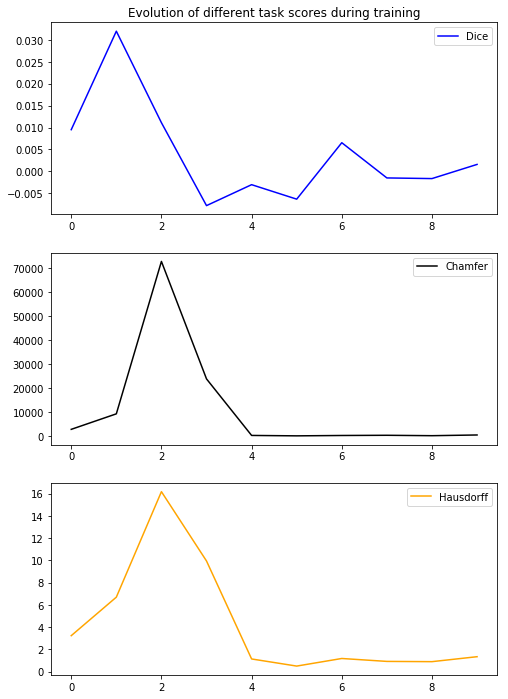

In [27]:
generator_gan, losses = train_Vanilla_GAN(point_cloud, mesh, 10, 64)
noise = torch.FloatTensor(np.random.randn(10000, 2)).cuda()
point_cloud_gan = generator_gan(noise).cpu().detach().numpy()
np.savetxt('pcd_gan.csv', point_cloud_gan, delimiter=',')

### 4.2) Train Generator with Chamfer distance

We will train a generator to minimize the following task loss for $P$ the generated point cloud and $Q$ the one from the true manifold:

 <h3 align="center"> $loss(P,Q) = \sum_{p\in P} \min_{q\in Q} \Vert p- q \Vert_2^2 + \sum_{q \in Q} \min_{p \in P} \Vert p - q \Vert_2^2$ </h3>
 
* We can see the first term as a regression task with "targets" found by running the Nearest Neighbor algorithm.
* To compute the second term, we use a greedy algorithm
* We give the possibility to train with only the second term of the loss by setting $\texttt{use_first_part_loss = False}$

In [28]:
class loss_second_part(nn.Module):
    
    def __init__(self):
        super(loss_second_part, self).__init__()
    
    def forward(self, P, Q):
        
        loss = 0
        
        for q in Q:
            
            loss += torch.min(torch.norm(P-q, dim=1))**2
        
        return(loss)

In [45]:
def train_Chamfer_Generator(point_cloud, mesh, n_epoch, mini_batch_size, use_first_part_loss = True,
                            compute_divergence = False , print_evolution = True, visualize = True):
    
    # initialize the parameters
    n_hidden = 3000
    latent_dim = 2
    input_dim = point_cloud.shape[1]
    n_points = len(point_cloud)
    
    # initialize the functions
    generator = Generator(latent_dim, input_dim, n_hidden).cuda()
    loss_left = nn.MSELoss(reduction='sum').cuda()
    loss_right = loss_second_part().cuda()
    #obj_func = objective_function_JSD()
    optim_gen = torch.optim.Adam(generator.parameters(), lr=1e-4, weight_decay=0.00001)
    #optim_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.00001)
    #optim_gen = torch.optim.SGD(generator.parameters(), lr=1e-3)
    neigh_Q = NearestNeighbors().fit(point_cloud)
    
    # to follow the evolution of the training
    begin = time.time()
    noise_batch = torch.FloatTensor(np.random.randn(n_points, latent_dim)).cuda()
    pcd = torch.FloatTensor(point_cloud).cuda()
    JSD, WD, Dice, Chamfer, Hausdorff = [0], [0], [], [], []
    
    # Initialize the parameters to compute the JSD and WD
    n_compute_divergences = n_epoch//10
    n_epoch_divergence = 30000
    b_size = 512
    epochs_div = []
    noise_div = torch.FloatTensor(np.random.randn(100*b_size, latent_dim)).cuda()
    pcd1, _, _ = generate_dataset(['bunny.ply'], 100*b_size, visualize=False)
    
    for epoch in range(n_epoch):
        
        np.random.shuffle(point_cloud)
        mse = 0
        
        for k in range(n_points//mini_batch_size):
            
            # sample generator mini_batch
            noise = torch.FloatTensor(np.random.randn(mini_batch_size, latent_dim)).cuda()
            mini_batch_fake = generator(noise)
        
            # Train generator
            optim_gen.zero_grad()
            mini_batch_fake_matrix = mini_batch_fake.cpu().detach().numpy()
            
            # targets_2 = torch.FloatTensor(greedy_targets(point_cloud[k*mini_batch_size:(k+1)*mini_batch_size], mini_batch_fake_matrix)).cuda()
            # loss_2 = loss(mini_batch_fake, targets_2)
            Q_mini_batch = torch.FloatTensor(point_cloud[k*mini_batch_size: (k+1)*mini_batch_size]).cuda()
            loss_2 = loss_right(mini_batch_fake, Q_mini_batch)
            
            if not use_first_part_loss:
                
                loss_2.backward()
                optim_gen.step()
            
            else:
                
                targets_indices = neigh_Q.kneighbors(mini_batch_fake_matrix, 1, return_distance=False)[:,0]
                targets = torch.FloatTensor(point_cloud[targets_indices]).cuda()
                loss_1 = loss_left(mini_batch_fake, targets)
                loss_g = loss_1 + loss_2
                loss_g.backward()
                optim_gen.step()
        
        # Compute the different indicators of training 
        pcd_fake_tensor = generator(noise_batch)
        pcd_fake_matrix = pcd_fake_tensor.cpu().detach().numpy()
        
        # Dice, Precision, Recall
        dice, precision, recall = voxel_volume_metric(mesh, pcd_fake_matrix, visualize = False)
        Dice.append(dice)
        # Chamfer
        Chamfer.append(compute_chamfer_distance(point_cloud, pcd_fake_matrix))
        # Hausdorff
        Hausdorff.append(compute_hausdorff_distance(point_cloud, pcd_fake_matrix))
        
        # Compute the two divergences, takes 10min on colab
        if epoch % n_compute_divergences == 0 and compute_divergence:
            
            print('\n', 'Computing the JSD and WD....', '\n')
            epochs_div.append(epoch)
            pcd2_tensor = generator(noise_div)
            pcd2 = pcd2_tensor.cpu().detach().numpy()
            jsd, wd = compute_two_divergences(pcd1, pcd2, n_epoch_divergence, b_size)
            JSD.append(jsd)
            WD.append(wd)
        
        if epoch % 10 == 0 and print_evolution:
            end = time.time()
            print('Epoch : %d Time taken so far: %.3f JSD: %.3f WD: %.3f Dice: %.3f Chamfer: %.3f Hausdorff: %.3f ' % (epoch, end-begin, JSD[-1], WD[-1], Dice[-1], Chamfer[-1], Hausdorff[-1]))
    
    if visualize:
        
        if compute_divergence:
        
            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, JSD, color='red')
            plt.title('Evolution of the approximated JSD during training')
            plt.show()

            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, WD, color='pink')
            plt.title('Evolution of the approximated WD during training')
            plt.show()
        
        plt.figure(1,figsize=(8,12))
        plt.subplot(311)
        plt.plot(range(n_epoch), Dice, color='blue', label='Dice')
        plt.title('Evolution of different task scores during training')
        plt.legend()
        plt.subplot(312)
        plt.plot(range(n_epoch), Chamfer, color='k', label='Chamfer')
        plt.legend()
        plt.subplot(313)
        plt.plot(range(n_epoch), Hausdorff, color='orange', label='Hausdorff')
        plt.legend()
        plt.show()
    
    dict_div = dict()
    dict_div['JSD'] = JSD
    dict_div['WD'] = WD
    dict_div['Dice'] = Dice
    dict_div['Chamfer'] = Chamfer
    dict_div['Hausdorff'] = Hausdorff
        
    return(generator, dict_div)

Epoch : 0 Time taken so far: 2.745 JSD: 0.000 WD: 0.000 Dice: 0.018 Chamfer: 286.917 Hausdorff: 1.658 


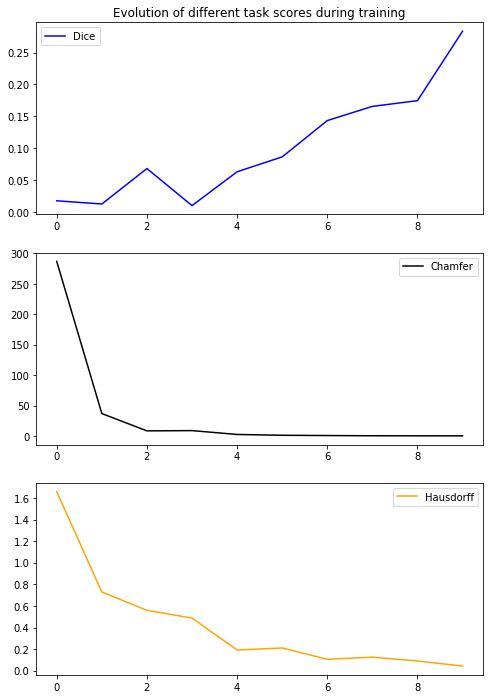

In [46]:
generator_chamfer, losses = train_Chamfer_Generator(point_cloud, mesh, 10, 100)
noise = torch.FloatTensor(np.random.randn(10000, 2)).cuda()
point_cloud_chamfer = generator_chamfer(noise).cpu().detach().numpy()
np.savetxt('pcd_chamfer.csv', point_cloud_chamfer, delimiter=',')

### 4.3) Train Generator with Nearest Neighbor in Latent space

The procedure for training it the following:

* Thanks to a manifold learning procedure *(we used [Umap]( https://umap-learn.readthedocs.io/en/latest/# ))* we "straighten" the point cloud $Q$ generated from the true manifold and embedd it in a latent space of dimension $d$. This new point cloud is named $Q_l$ 
* We rescale $Q_l$ so that the points fit in the $[-0.5,0.5]$ hypercube
* We fit a nearest neighbor procedure on $Q_l$
* During the training of the generator $g_\theta$, we generate input points $z \sim \mathcal{U}([-0.5,0.5])$. For each $z$, we find its nearest neighbor $q_l$ in $Q_l$ and retrieve the corresponding point $q$ from $Q$
* We use $q$ as the target of $g_\theta(z)$ in a regression task using the $L_2$ loss

In [31]:
import umap

In [32]:
def rescale(data):
    
    """ Rescale and move the data so that it fits inside the [0,1] hypercube"""
    
    min_data = np.min(data, axis=0)
    max_data = np.max(data, axis=0)
    data_new = (data - min_data)/(max_data-min_data) - 0.5
    
    return(data_new)

In [65]:
def train_NN_Latent_Generator(point_cloud, mesh, n_epoch, mini_batch_size, compute_divergence = False,
                              print_evolution = True, visualize = True):
    
    # initialize the parameters
    n_hidden = 3000
    latent_dim = 2
    input_dim = point_cloud.shape[1]
    n_points = len(point_cloud)
    
    # initialize the functions
    generator = Generator(latent_dim, input_dim, n_hidden).cuda()
    loss = nn.MSELoss().cuda()
    #obj_func = objective_function_JSD()
    optim_gen = torch.optim.Adam(generator.parameters(), lr=1e-4, weight_decay=0.00001)
    #optim_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.00001)
    #optim_gen = torch.optim.SGD(generator.parameters(), lr=1e-3)
    
    # find the latent representation of the point cloud using
    # a manifold learning technique. We use UMAP
    print('Finding a good latent representation for the manifold...')
    time1 = time.time()
    trans = umap.UMAP(n_neighbors=50, min_dist = 0.5, n_components=latent_dim).fit(point_cloud)
    pcd_latent = rescale(trans.embedding_)
    time2 = time.time()
    print('Latent representation computed. Time taken = %.2f' %(time2-time1))
    
    # fit the nearest neighbors in latent space
    neigh_Q = NearestNeighbors().fit(pcd_latent)
    
    # to follow the evolution of the training
    begin = time.time()
    noise_batch = torch.FloatTensor(np.random.uniform(-0.5, 0.5, size=(n_points, latent_dim))).cuda()
    pcd = torch.FloatTensor(point_cloud).cuda()
    JSD, WD, Dice, Chamfer, Hausdorff, MSE = [0], [0], [], [], [], []
    
    # Initialize the parameters to compute the JSD and WD
    n_compute_divergences = n_epoch//10
    n_epoch_divergence = 30000
    b_size = 512
    epochs_div = []
    noise_div = torch.FloatTensor(np.random.uniform(-0.5, 0.5, size=(100*b_size, latent_dim))).cuda()
    pcd1, _, _ = generate_dataset(['bunny.ply'], 100*b_size, visualize=False)
    
    for epoch in range(n_epoch):
        
        np.random.shuffle(point_cloud)
        mse = 0
        
        for k in range(n_points//mini_batch_size):
            
            # sample generator mini_batch
            noise = torch.FloatTensor(np.random.uniform(-0.5, 0.5, size=(mini_batch_size, latent_dim))).cuda()
            noise_matrix = noise.cpu().detach().numpy()
            mini_batch_fake = generator(noise)
        
            # Train generator
            optim_gen.zero_grad()
            mini_batch_fake_matrix = mini_batch_fake.cpu().detach().numpy()
            ## find the targets in latent space
            targets_indices = neigh_Q.kneighbors(noise.cpu().detach().numpy(), 1, return_distance=False)[:,0]
            targets = torch.FloatTensor(point_cloud[targets_indices]).cuda()
            ## compute the L2 loss
            loss_g = loss(mini_batch_fake, targets)
            loss_g.backward()
            optim_gen.step()
            
            mse += float(loss_g)*mini_batch_size
        
        # Compute the different indicators of training 
        pcd_fake_tensor = generator(noise_batch)
        pcd_fake_matrix = pcd_fake_tensor.cpu().detach().numpy()
        
        # Dice, Precision, Recall
        dice, precision, recall = voxel_volume_metric(mesh, pcd_fake_matrix, visualize = False)
        Dice.append(dice)
        # Chamfer
        Chamfer.append(compute_chamfer_distance(point_cloud, pcd_fake_matrix))
        # Hausdorff
        Hausdorff.append(compute_hausdorff_distance(point_cloud, pcd_fake_matrix))
        # MSE
        MSE.append(mse/n_points)
        
        # Compute the two divergences, takes 10min on colab
        if epoch % n_compute_divergences == 0 and compute_divergence:
            
            print('\n', 'Computing the JSD and WD....', '\n')
            epochs_div.append(epoch)
            pcd2_tensor = generator(noise_div)
            pcd2 = pcd2_tensor.cpu().detach().numpy()
            jsd, wd = compute_two_divergences(pcd1, pcd2, n_epoch_divergence, b_size)
            JSD.append(jsd)
            WD.append(wd)
        
        if epoch % 10 == 0 and print_evolution:
            end = time.time()
            print('Epoch : %d MSE : %.4f Time taken so far: %.3f JSD: %.3f WD: %.3f Dice: %.3f Chamfer: %.3f Hausdorff: %.3f ' % (epoch, MSE[-1], end-begin, JSD[-1], WD[-1], Dice[-1], Chamfer[-1], Hausdorff[-1]))
    
    if visualize:
        
        if compute_divergence:
            
            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, JSD, color='red')
            plt.title('Evolution of the approximated JSD during training')
            plt.show()

            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, WD, color='pink')
            plt.title('Evolution of the approximated WD during training')
            plt.show()
        
        plt.figure(1,figsize=(8,16))
        plt.subplot(411)
        plt.plot(range(n_epoch), Dice, color='blue', label='Dice')
        plt.title('Evolution of different task scores during training')
        plt.legend()
        plt.subplot(412)
        plt.plot(range(n_epoch), Chamfer, color='k', label='Chamfer')
        plt.legend()
        plt.subplot(413)
        plt.plot(range(n_epoch), Hausdorff, color='orange', label='Hausdorff')
        plt.legend()
        plt.subplot(414)
        plt.plot(range(n_epoch), MSE, color='pink', label='MSE')
        plt.legend()
        plt.show()
    
    dict_div = dict()
    dict_div['JSD'] = JSD
    dict_div['WD'] = WD
    dict_div['Dice'] = Dice
    dict_div['Chamfer'] = Chamfer
    dict_div['Hausdorff'] = Hausdorff
    dict_div['MSE'] = MSE
        
    return(generator, dict_div)

In [ ]:
generator_NN_latent, dict_div = train_NN_Latent_Generator(point_cloud, mesh, 1, 1000)
noise = torch.FloatTensor(np.random.randn(10000, 2)).cuda()
point_cloud_NN_latent = generator_NN_latent(noise).cpu().detach().numpy()
np.savetxt('pcd_NN_latent.csv', point_cloud_NN_latent, delimiter=',')

### 4.4) Train Generator using Hausdorff loss

 <h3 align="center"> $\tilde{H}(P,Q) = \max_{p \in P} \Big( \min_{q \in Q} \Vert p - q \Vert_2 \Big)$ </h3>
 <h3 align="center"> $loss(P,Q) = \max \{ \tilde{H}(P,Q), \tilde{H}(Q,P) \}$ </h3>

In [39]:
class loss_Hausdorff(nn.Module):
    
    def __init__(self):
        super(loss_Hausdorff, self).__init__()
    
    def forward(self, P, Q):
        
        hausdorff_loss = 0
        
        for q in Q:
            
            loss =  torch.min(torch.norm(P-q, dim=1))
            
            if loss > hausdorff_loss:
                
                hausdorff_loss = loss
        
        for p in P:
            
            loss =  torch.min(torch.norm(Q-p, dim=1))
            
            if loss > hausdorff_loss:
                
                hausdorff_loss = loss
        
        return(hausdorff_loss)

In [40]:
def train_Hausdorff_Generator(point_cloud, mesh, n_epoch, mini_batch_size,
                            compute_divergence = False , print_evolution = True, visualize = True):
    
    # initialize the parameters
    n_hidden = 3000
    latent_dim = 2
    input_dim = point_cloud.shape[1]
    n_points = len(point_cloud)
    
    # initialize the functions
    generator = Generator(latent_dim, input_dim, n_hidden).cuda()
    loss = loss_Hausdorff().cuda()
    #obj_func = objective_function_JSD()
    optim_gen = torch.optim.Adam(generator.parameters(), lr=1e-4, weight_decay=0.00001)
    #optim_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.00001)
    #optim_gen = torch.optim.SGD(generator.parameters(), lr=1e-3)
    
    # to follow the evolution of the training
    begin = time.time()
    noise_batch = torch.FloatTensor(np.random.randn(n_points, latent_dim)).cuda()
    pcd = torch.FloatTensor(point_cloud).cuda()
    JSD, WD, Dice, Chamfer, Hausdorff = [0], [0], [], [], []
    
    # Initialize the parameters to compute the JSD and WD
    n_compute_divergences = n_epoch//10
    n_epoch_divergence = 30000
    b_size = 512
    epochs_div = []
    noise_div = torch.FloatTensor(np.random.randn(100*b_size, latent_dim)).cuda()
    pcd1, _, _ = generate_dataset(['bunny.ply'], 100*b_size, visualize=False)
    
    for epoch in range(n_epoch):
        
        np.random.shuffle(point_cloud)
        mse = 0
        
        for k in range(n_points//mini_batch_size):
            
            # sample generator mini_batch
            noise = torch.FloatTensor(np.random.randn(mini_batch_size, latent_dim)).cuda()
            mini_batch_fake = generator(noise)
        
            # Train generator
            optim_gen.zero_grad()
            mini_batch_fake_matrix = mini_batch_fake.cpu().detach().numpy()
            
            Q_mini_batch = torch.FloatTensor(point_cloud[k*mini_batch_size: (k+1)*mini_batch_size]).cuda()
            loss_g = loss(mini_batch_fake, Q_mini_batch)
            loss_g.backward()
            optim_gen.step()
        
        # Compute the different indicators of training 
        pcd_fake_tensor = generator(noise_batch)
        pcd_fake_matrix = pcd_fake_tensor.cpu().detach().numpy()
        
        # Dice, Precision, Recall
        dice, precision, recall = voxel_volume_metric(mesh, pcd_fake_matrix, visualize = False)
        Dice.append(dice)
        # Chamfer
        Chamfer.append(compute_chamfer_distance(point_cloud, pcd_fake_matrix))
        # Hausdorff
        Hausdorff.append(compute_hausdorff_distance(point_cloud, pcd_fake_matrix))
        
        # Compute the two divergences, takes 10min on colab
        if epoch % n_compute_divergences == 0 and compute_divergence:
            
            print('\n', 'Computing the JSD and WD....', '\n')
            epochs_div.append(epoch)
            pcd2_tensor = generator(noise_div)
            pcd2 = pcd2_tensor.cpu().detach().numpy()
            jsd, wd = compute_two_divergences(pcd1, pcd2, n_epoch_divergence, b_size)
            JSD.append(jsd)
            WD.append(wd)
        
        if epoch % 10 == 0 and print_evolution:
            end = time.time()
            print('Epoch : %d Time taken so far: %.3f JSD: %.3f WD: %.3f Dice: %.3f Chamfer: %.3f Hausdorff: %.3f ' % (epoch, end-begin, JSD[-1], WD[-1], Dice[-1], Chamfer[-1], Hausdorff[-1]))
    
    if visualize:
        
        if compute_divergence:
        
            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, JSD, color='red')
            plt.title('Evolution of the approximated JSD during training')
            plt.show()

            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, WD, color='pink')
            plt.title('Evolution of the approximated WD during training')
            plt.show()
        
        plt.figure(1,figsize=(8,12))
        plt.subplot(311)
        plt.plot(range(n_epoch), Dice, color='blue', label='Dice')
        plt.title('Evolution of different task scores during training')
        plt.legend()
        plt.subplot(312)
        plt.plot(range(n_epoch), Chamfer, color='k', label='Chamfer')
        plt.legend()
        plt.subplot(313)
        plt.plot(range(n_epoch), Hausdorff, color='orange', label='Hausdorff')
        plt.legend()
        plt.show()
    
    dict_div = dict()
    dict_div['JSD'] = JSD
    dict_div['WD'] = WD
    dict_div['Dice'] = Dice
    dict_div['Chamfer'] = Chamfer
    dict_div['Hausdorff'] = Hausdorff
        
    return(generator, dict_div)

Epoch : 0 Time taken so far: 2.443 JSD: 0.000 WD: 0.000 Dice: -0.015 Chamfer: 200.167 Hausdorff: 1.783 


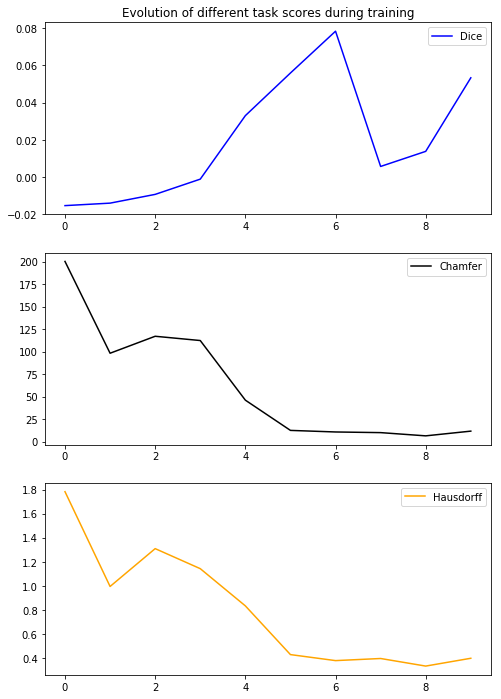

In [41]:
generator_Hausdorff, losses = train_Hausdorff_Generator(point_cloud, mesh, 10, 100, compute_divergence = False , print_evolution = True, visualize = True)
noise = torch.FloatTensor(np.random.randn(10000, 2)).cuda()
point_cloud_Hausdorff = generator_chamfer(noise).cpu().detach().numpy()
np.savetxt('pcd_Hausdorff.csv', point_cloud_Hausdorff, delimiter=',')

### 4.5) Train Generator using Sinkhorn divergences

* The definition of those divergences are available here : https://arxiv.org/abs/1810.08278
* We use the loss implemented in the package [GeomLoss]( http://www.kernel-operations.io/geomloss/ )

In [23]:
from geomloss import SamplesLoss

In [43]:
def train_Sinkhorn_Generator(point_cloud, mesh, n_epoch, mini_batch_size,
                            compute_divergence = False , print_evolution = True, visualize = True):
    
    # initialize the parameters
    n_hidden = 3000
    latent_dim = 2
    input_dim = point_cloud.shape[1]
    n_points = len(point_cloud)
    
    # initialize the functions
    generator = Generator(latent_dim, input_dim, n_hidden).cuda()
    loss = SamplesLoss(loss="sinkhorn", p=2).cuda()
    #obj_func = objective_function_JSD()
    optim_gen = torch.optim.Adam(generator.parameters(), lr=1e-4, weight_decay=0.00001)
    #optim_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.00001)
    #optim_gen = torch.optim.SGD(generator.parameters(), lr=1e-3)
    
    # to follow the evolution of the training
    begin = time.time()
    noise_batch = torch.FloatTensor(np.random.randn(n_points, latent_dim)).cuda()
    pcd = torch.FloatTensor(point_cloud).cuda()
    JSD, WD, Dice, Chamfer, Hausdorff, Sinkhorn = [0], [0], [], [], [], []
    
    # Initialize the parameters to compute the JSD and WD
    n_compute_divergences = n_epoch//10
    n_epoch_divergence = 30000
    b_size = 512
    epochs_div = []
    noise_div = torch.FloatTensor(np.random.randn(100*b_size, latent_dim)).cuda()
    pcd1, _, _ = generate_dataset(['bunny.ply'], 100*b_size, visualize=False)
    
    for epoch in range(n_epoch):
        
        np.random.shuffle(point_cloud)
        mse = 0
        
        for k in range(n_points//mini_batch_size):
            
            # sample generator mini_batch
            noise = torch.FloatTensor(np.random.randn(mini_batch_size, latent_dim)).cuda()
            mini_batch_fake = generator(noise)
        
            # Train generator
            optim_gen.zero_grad()
            mini_batch_fake_matrix = mini_batch_fake.cpu().detach().numpy()
            
            Q_mini_batch = torch.FloatTensor(point_cloud[k*mini_batch_size: (k+1)*mini_batch_size]).cuda()
            loss_g = loss(mini_batch_fake, Q_mini_batch)
            loss_g.backward()
            optim_gen.step()
        
        # Compute the different indicators of training 
        pcd_fake_tensor = generator(noise_batch)
        pcd_fake_matrix = pcd_fake_tensor.cpu().detach().numpy()
        
        # Dice, Precision, Recall
        dice, precision, recall = voxel_volume_metric(mesh, pcd_fake_matrix, visualize = False)
        Dice.append(dice)
        # Chamfer
        Chamfer.append(compute_chamfer_distance(point_cloud, pcd_fake_matrix))
        # Hausdorff
        Hausdorff.append(compute_hausdorff_distance(point_cloud, pcd_fake_matrix))
        # Sinkhorn divergence
        Sinkhorn.append(float(loss(pcd, pcd_fake_tensor)))
        
        # Compute the two divergences, takes 10min on colab
        if epoch % n_compute_divergences == 0 and compute_divergence:
            
            print('\n', 'Computing the JSD and WD....', '\n')
            epochs_div.append(epoch)
            pcd2_tensor = generator(noise_div)
            pcd2 = pcd2_tensor.cpu().detach().numpy()
            jsd, wd = compute_two_divergences(pcd1, pcd2, n_epoch_divergence, b_size)
            JSD.append(jsd)
            WD.append(wd)
        
        if epoch % 10 == 0 and print_evolution:
            end = time.time()
            print('Epoch : %d Sinkhorn: %.3f Time taken so far: %.3f JSD: %.3f WD: %.3f Dice: %.3f Chamfer: %.3f Hausdorff: %.3f ' % (epoch, Sinkhorn[-1], end-begin, JSD[-1], WD[-1], Dice[-1], Chamfer[-1], Hausdorff[-1]))
    
    if visualize:
        
        if compute_divergence:
        
            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, JSD, color='red')
            plt.title('Evolution of the approximated JSD during training')
            plt.show()

            plt.figure(1,figsize=(8,4))
            plt.plot(epochs_div, WD, color='pink')
            plt.title('Evolution of the approximated WD during training')
            plt.show()
        
        plt.figure(1,figsize=(8,16))
        plt.subplot(311)
        plt.plot(range(n_epoch), Dice, color='blue', label='Dice')
        plt.title('Evolution of different task scores during training')
        plt.legend()
        plt.subplot(312)
        plt.plot(range(n_epoch), Chamfer, color='k', label='Chamfer')
        plt.legend()
        plt.subplot(313)
        plt.plot(range(n_epoch), Hausdorff, color='orange', label='Hausdorff')
        plt.legend()
        plt.subplot(414)
        plt.plot(range(n_epoch), Sinkhorn, color='green', label='Sinkhorn')
        plt.legend()
        plt.show()
    
    dict_div = dict()
    dict_div['JSD'] = JSD
    dict_div['WD'] = WD
    dict_div['Dice'] = Dice
    dict_div['Chamfer'] = Chamfer
    dict_div['Hausdorff'] = Hausdorff
    dict_div['Sinkhorn'] = Sinkhorn
        
    return(generator, dict_div)

Epoch : 0 Sinkhorn: 2.139 Time taken so far: 1.488 JSD: 0.000 WD: 0.000 Dice: 0.003 Chamfer: 5624.082 Hausdorff: 4.273 


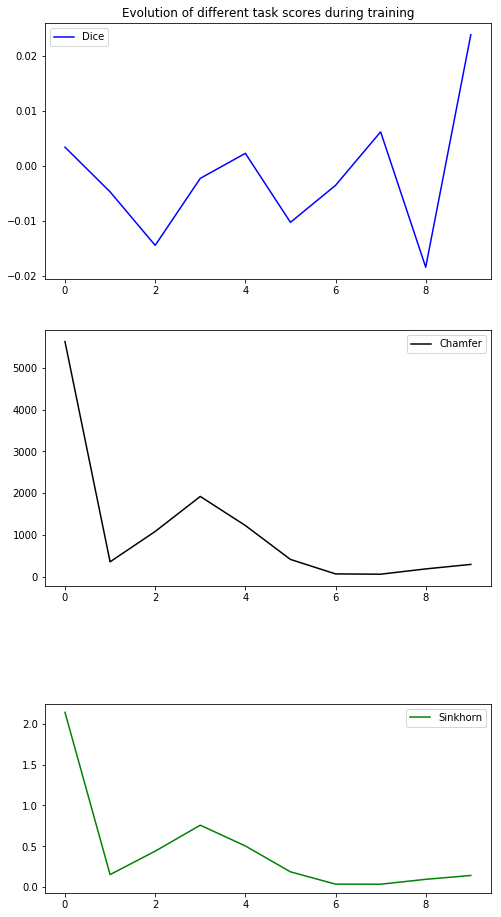

In [44]:
generator_Sinkhorn, losses = train_Sinkhorn_Generator(point_cloud, mesh, 10, 1000, compute_divergence = False , print_evolution = True, visualize = True)
noise = torch.FloatTensor(np.random.randn(10000, 2)).cuda()
point_cloud_sinkhorn = generator_chamfer(noise).cpu().detach().numpy()
np.savetxt('pcd_sinkhorn.csv', point_cloud_sinkhorn, delimiter=',')

## Visualization

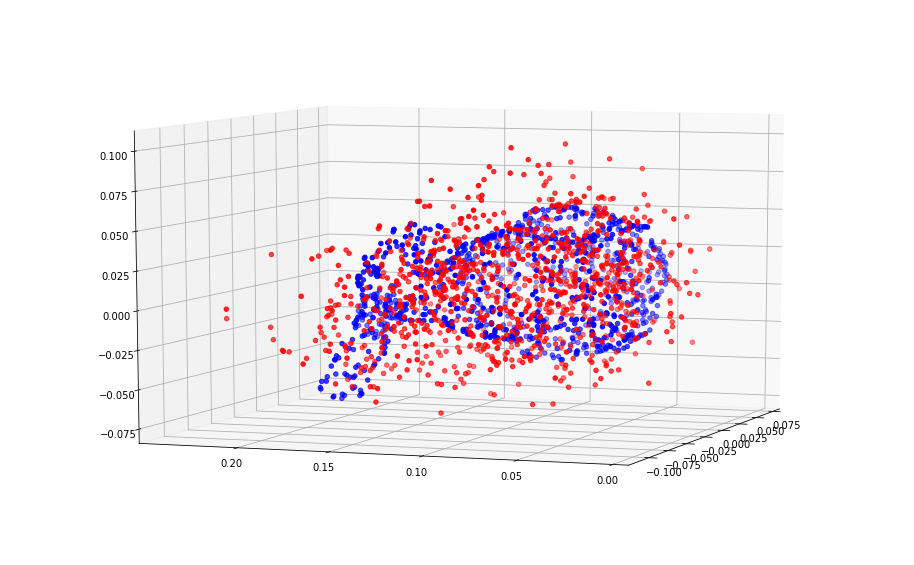

In [209]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

# np.savetxt("point_cloud.csv", points_cloud, delimiter=",")
# points_fake = generator(torch.FloatTensor(np.random.randn(1000, 2)).cuda()).cpu().detach().numpy()
points_fake = np.loadtxt('points_fake11.csv', delimiter=',')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_fake[:,0], points_fake[:,1], points_fake[:,2], c='red')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], c='blue')
ax.view_init(8, 200)
plt.show()

In [34]:
#points_fake = generator(torch.FloatTensor(np.random.randn(1000, 2)).cuda()).cpu().detach().numpy()
points_fake = np.loadtxt('pcd_sinkhorn_bunny_dragon.csv', delimiter=',')
#points_fake = np.load('10000_VanGANDragon.npy')
pcd_fake = o3.PointCloud()
pcd_fake.points = o3.Vector3dVector(points_fake)
pcd_fake.paint_uniform_color([1, 0.706, 0])

#point_cloud_bun, gaps, mesh = generate_dataset(['bunny.ply', 'dragon.ply'], 5000, visualize=False)

points_true = point_cloud_bun
pcd_true = o3.PointCloud()
pcd_true.points = o3.Vector3dVector(points_true)
pcd_true.paint_uniform_color([1, 0, 0])

dice, precision, recall = voxel_volume_metric(mesh, points_fake, visualize = False)
ch = compute_chamfer_distance(point_cloud_bun, points_fake)
hs = compute_hausdorff_distance(point_cloud_bun, points_fake)
print(dice, ch, hs)


o3.draw_geometries([pcd_fake])
visualizer = JVisualizer()
#visualizer.add_geometry(pcd_true)
visualizer.add_geometry(pcd_fake)
visualizer.show()

0.08192453451969023 0.8108594014493774 0.022724313623130564


JVisualizer with 1 geometries